In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("chunk30.csv")
df = df.drop(['ECG', 'Trigger'], axis=1)

In [5]:
df.columns

Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2',
       'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz'],
      dtype='object')

## Filter data

In [8]:
from CCDLUtil.SignalProcessing.Filters import butter_bandpass_filter

In [9]:
for col in df:
    df[col] = butter_bandpass_filter(df[col], 1, 50, 500)

## Fast ICA

In [11]:
from sklearn.decomposition import FastICA

In [14]:
model = FastICA(whiten=True)
source = model.fit_transform(df)

In [33]:
import numpy as np
from numpy.linalg import norm
from scipy.interpolate import griddata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

source = source.T

In [ ]:
sns.set()
X = np.arange(1500)
fig, axes = plt.subplots(nrows=12, ncols=1, sharex=True)
for i, ax in enumerate(axes):
    ax.plot(X, source[i, 2000:3500])

fig.set_size_inches(20, 80)

In [24]:
model.mixing_.shape

(31, 31)

## Topography

In [17]:
BRAINAMP_CHANNEL_LIST = [
    (3.76, 8.80),     # Fp1
    (6.24, 8.80),     # Fp2
    (3.38, 7.10),     # F3
    (6.62, 7.10),     # F4
    (3.0, 5.0),       # C3
    (7.0, 5.0),       # C4
    (3.38, 2.90),     # P3
    (6.62, 2.90),     # P4
    (3.76, 1.20),     # O1
    (6.24, 1.20),     # O2
    (1.76, 7.35),     # F7
    (8.24, 7.35),     # F8
    (1.0, 5.0),       # T7
    (9.0, 5.0),       # T8
    (1.76, 2.65),     # P7
    (8.24, 2.65),     # P8
    (5.00, 7.00),     # Fz
    (5.00, 5.00),     # Cz
    (5.00, 3.00),     # Pz
    (5.00, 1.00),     # Oz
    (4.19, 6.0),      # FC1
    (5.81, 6.0),      # FC2
    (4.19, 4.0),      # CP1
    (5.81, 4.0),      # CP2
    (2.0, 6.33),      # FC5
    (8.0, 6.33),      # FC6
    (2.0, 3.67),      # CP5
    (8.0, 3.67),      # CP6
    (0.5, 3.13),      # TP9
    (9.5, 3.13),      # TP10
    (5.0, 2.0)        # POz
]

In [18]:
def crop(xi, yi, data, center, radius):
    """
    Crop the region outside of the circle
    """
    for ii, i in enumerate(xi):
        for jj, j in enumerate(yi):
            if norm([center[0] - i, center[1] - j]) - 0.03 > radius:
                data[ii][jj] = float("nan")

In [44]:
def microstate_topo(peak_data, index, N=150, save=False):
    """
    Create topology mapping of channel voltages at GFP peaks
    """
    # interpolation
    sns.set()
    xi = np.linspace(0, 10, N)
    yi = np.linspace(0, 10, N)
    coords = np.zeros(len(BRAINAMP_CHANNEL_LIST) * 2).reshape((len(BRAINAMP_CHANNEL_LIST), 2))
    for i, c in enumerate(BRAINAMP_CHANNEL_LIST):
        coords[i, 0] = c[0]
        coords[i, 1] = c[1]
    # cubic interpolation
    zi = griddata(coords, peak_data, (xi[None, :], yi[:, None]), method='cubic')
    crop(xi, yi, zi, [5, 5], 3.8)
    # start drawing
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(5, 5)
    ax.set_xlim((0, 10))
    ax.set_ylim((0, 10))
    head = matplotlib.patches.Circle([5, 5], radius=3.8, edgecolor="k", facecolor="none")
    ax.add_patch(head)
    ax.contourf(xi, yi, zi, 60, cmap="coolwarm", zorder=1)
    # save (REMEMBER TO CHANGE FOR OTHER SUBJECTS NAME)
    if save:
        save_dir = os.path.abspath("../Result/Microstate_topo/4-29/1_Y3/")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, "4-29_1_Y3_" + str(index)))
        plt.cla()
    else:
        plt.show()

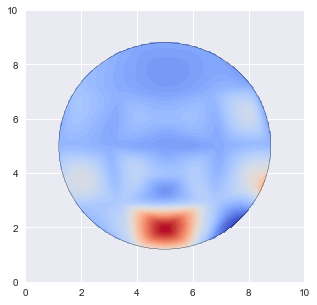

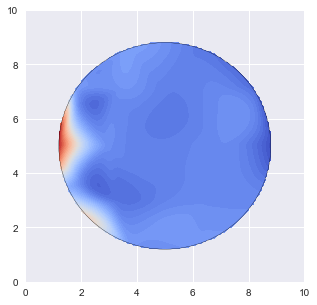

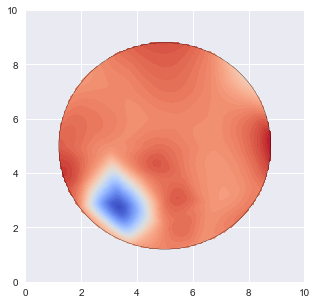

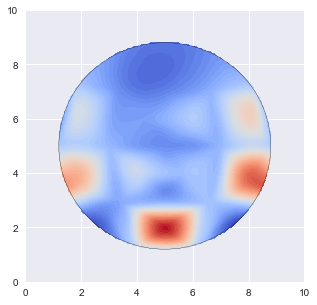

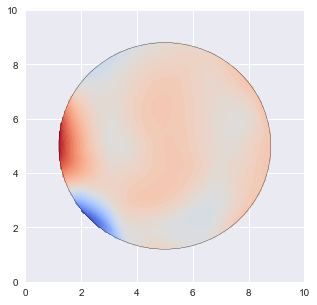

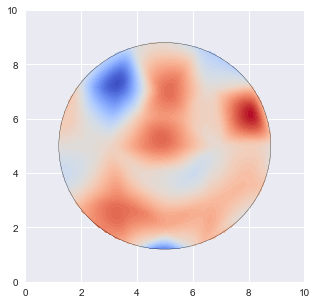

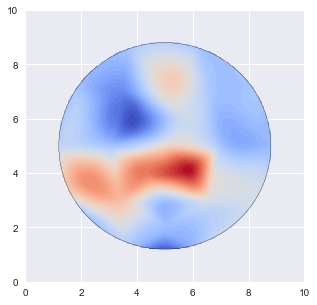

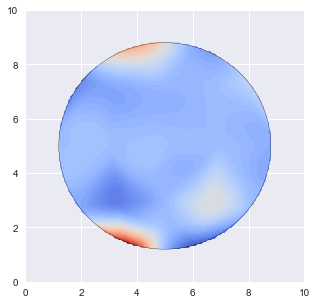

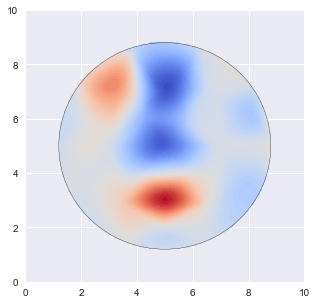

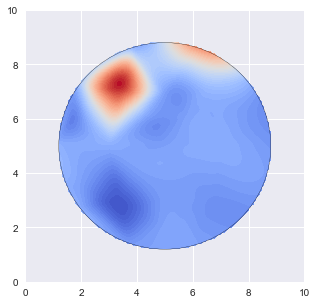

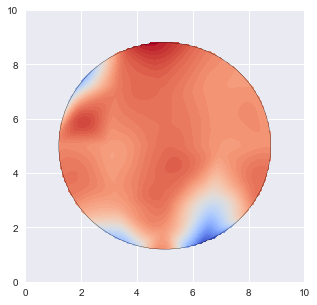

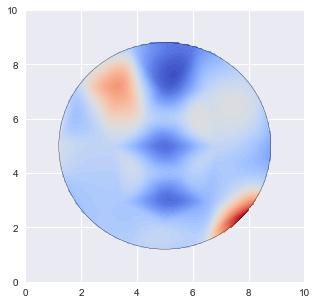

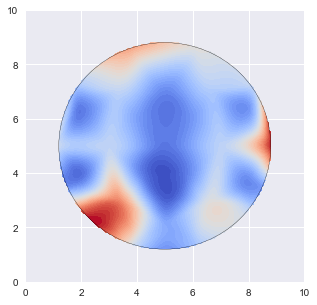

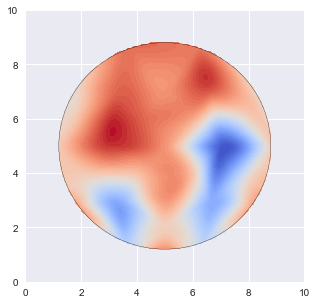

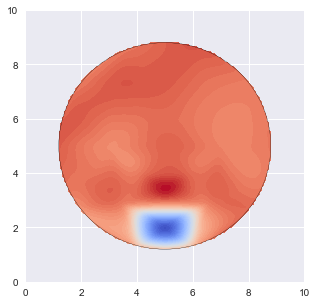

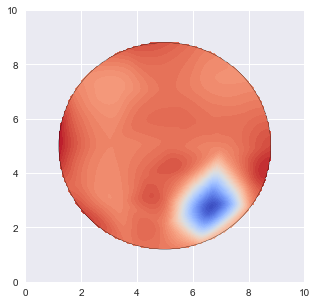

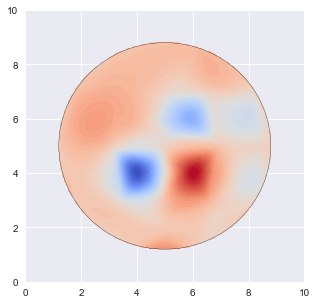

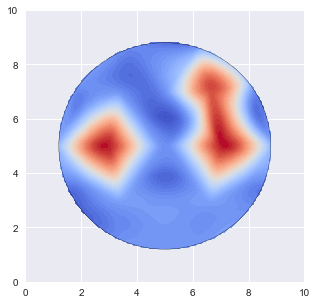

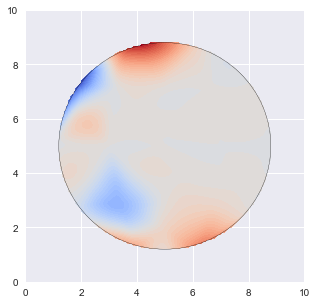

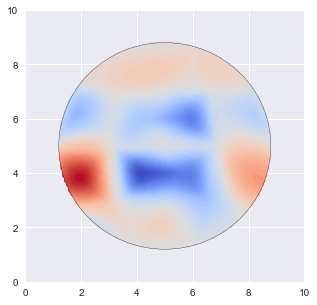

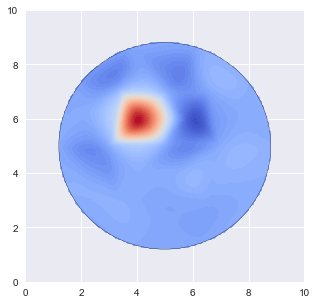

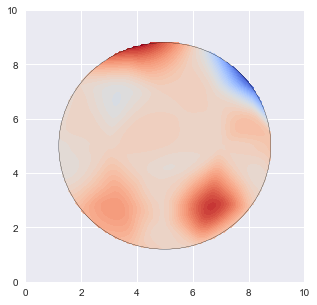

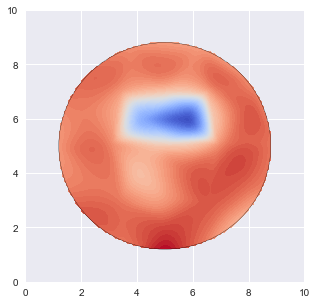

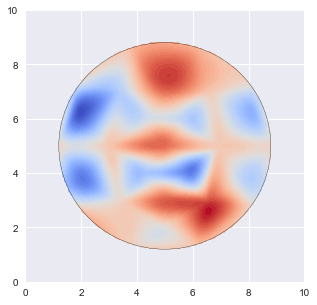

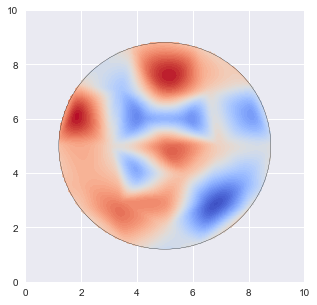

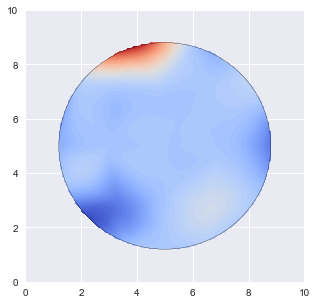

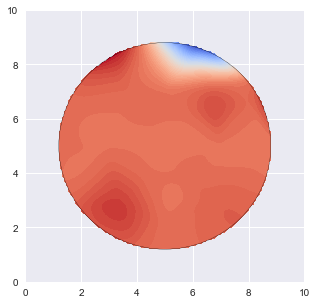

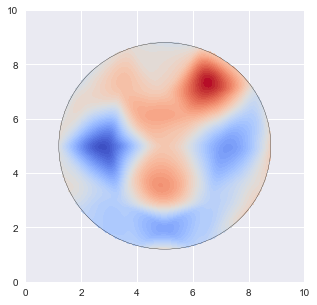

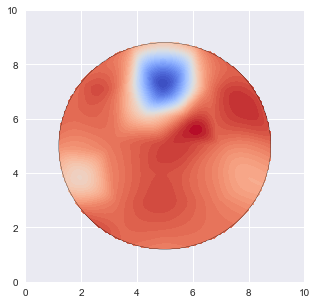

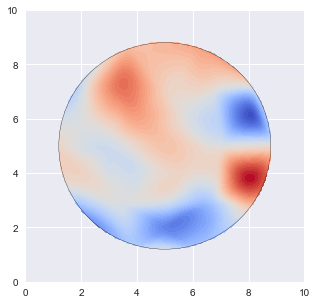

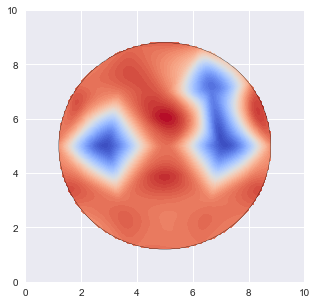

In [45]:
for i in range(model.mixing_.shape[1]):
    microstate_topo(model.mixing_[:, i], None)